In [2]:
!date

Sun Mar 13 12:55:21 PDT 2022


This is Bean Machine's [Linear Regression Tutorial](https://github.com/facebookresearch/beanmachine/blob/5ead2f65556ea8a0e420f4b54ed9fb064727889a/tutorials/Linear_Regression.ipynb).

In [3]:
from typing import Optional, Tuple

import altair
import beanmachine.ppl as bm
import pandas as pd
import sklearn.model_selection
import torch
import torch.distributions as dist


In [3]:
def make_trace_plot_for_one_parameter(
    df_samples: pd.DataFrame,
    parameter: str,
    skip_first: int,
    subsample: int,
    extent: Tuple[float, float],
    true_value: Optional[float] = None,
):
    trace = (
        altair.Chart()
        .mark_line()
        .encode(
            altair.X("draw"),
            altair.Y(parameter, scale=altair.Scale(zero=False)),
            altair.Color("chain:N"),
        )
    )
    density = (
        altair.Chart()
        .transform_density(
            density=parameter,
            bandwidth=0.1,
            groupby=["chain"],
            extent=extent,
            counts=True,
            steps=50,
        )
        .mark_line()
        .encode(
            altair.X("value:Q", title=parameter),
            altair.Y("density:Q"),
            altair.Color("chain:N"),
        )
    )
    if true_value is not None:
        density += altair.Chart().mark_rule(size=3).encode(x=altair.datum(true_value))

    return altair.hconcat(
        trace,
        density,
        data=df_samples.loc[lambda df: df["draw"] >= skip_first][::subsample],
    )


In [4]:
bm.seed(883355)

$$
\begin{align}
y & \sim \mathcal{N}(\beta_0 + \beta_1 x, \sigma) \\
\beta_0 & \sim \mathcal{N}(0, 10) \\
\beta_1 & \sim \mathcal{N}(0, 10) \\
\sigma & \sim \mathrm{Gamma}(1, 1) \\
\end{align}

In [5]:
@bm.random_variable
def beta_0() -> dist.Distribution:
    return dist.Normal(0, 10)


@bm.random_variable
def beta_1() -> dist.Distribution:
    return dist.Normal(0, 10)


@bm.random_variable
def sigma() -> dist.Distribution:
    return dist.Gamma(1, 1)


@bm.random_variable
def y(X: torch.Tensor) -> dist.Distribution:
    return dist.Normal(beta_0() + beta_1() * X, sigma())

In [6]:
N = 200

X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_0 = 5.
true_beta_1 = 2.
true_sigma = 1.
Y = dist.Normal(true_beta_0 + true_beta_1 * X, true_sigma).sample()

In [7]:
altair.Chart(pd.DataFrame({"X": X.squeeze(), "Y": Y.squeeze()})).mark_point().encode(
    x="X", y="Y"
)


alt.Chart(...)

In [8]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X, Y, random_state=440099
)


In [9]:
observations = {y(X_train): Y_train}

In [10]:
num_samples = 4000
num_chains = 4

In [11]:
bm.seed(883344)
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=num_samples,
    num_chains=num_chains,
)


Samples collected: 100%|██████████| 4000/4000 [00:05<00:00, 733.39it/s] 


In [12]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.001378,0.110605,4.831777,4.996375,5.180544,1.018277,218.967697
beta_1()[],2.050734,0.162495,1.810693,2.060409,2.277894,1.019693,206.826721
sigma()[],0.984938,0.096457,0.869731,0.979193,1.106868,1.005291,799.211975


In [14]:
df_expected = pd.DataFrame.from_dict(
    {
        "avg": {
            "beta_0()[]": 4.994120121002197,
            "beta_1()[]": 2.0545616149902344,
            "sigma()[]": 0.9820095300674438,
        },
        "std": {
            "beta_0()[]": 0.15791670978069305,
            "beta_1()[]": 0.15471333265304565,
            "sigma()[]": 0.0892559215426445,
        },
        "2.5%": {
            "beta_0()[]": 4.816328632831573,
            "beta_1()[]": 1.8859071731567383,
            "sigma()[]": 0.8706023693084717,
        },
        "50%": {
            "beta_0()[]": 4.987343788146973,
            "beta_1()[]": 2.051696538925171,
            "sigma()[]": 0.9733794331550598,
        },
        "97.5%": {
            "beta_0()[]": 5.17110538482666,
            "beta_1()[]": 2.292750120162964,
            "sigma()[]": 1.126818299293518,
        },
        "r_hat": {
            "beta_0()[]": 1.0022523403167725,
            "beta_1()[]": 1.0131890773773193,
            "sigma()[]": 1.0030386447906494,
        },
        "n_eff": {
            "beta_0()[]": 384.150634765625,
            "beta_1()[]": 194.3146514892578,
            "sigma()[]": 431.8768005371094,
        },
    }
)


In [15]:
pd.testing.assert_frame_equal(bm.Diagnostics(samples_mh).summary(), df_expected)

AssertionError: DataFrame.iloc[:, 0] (column name="avg") are different

DataFrame.iloc[:, 0] (column name="avg") values are different (100.0 %)
[index]: [beta_0()[], beta_1()[], sigma()[]]
[left]:  [5.001377582550049, 2.050733804702759, 0.9849380254745483]
[right]: [4.994120121002197, 2.0545616149902344, 0.9820095300674438]

In [ ]:
df_samples = (
    samples_mh.to_xarray()
    .to_dataframe()
    .reset_index()
    .rename(columns={beta_0(): "beta_0", beta_1(): "beta_1", sigma(): "sigma"})
)


In [ ]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chain   16000 non-null  int64  
 1   draw    16000 non-null  int64  
 2   beta_0  16000 non-null  float32
 3   sigma   16000 non-null  float32
 4   beta_1  16000 non-null  float32
dtypes: float32(3), int64(2)
memory usage: 437.6 KB


In [ ]:
summary_chart = (
    make_trace_plot_for_one_parameter(
        df_samples,
        parameter="beta_0",
        skip_first=100,
        subsample=5,
        extent=(4.5, 5.5),
        true_value=true_beta_0,
    )
    & make_trace_plot_for_one_parameter(
        df_samples,
        parameter="beta_1",
        skip_first=100,
        subsample=5,
        extent=(1.5, 2.5),
        true_value=true_beta_1,
    )
    & make_trace_plot_for_one_parameter(
        df_samples,
        parameter="sigma",
        skip_first=100,
        subsample=5,
        extent=(0.5, 1.5),
        true_value=true_sigma,
    )
)


In [ ]:
summary_chart

alt.VConcatChart(...)

In [ ]:
assert False

# BMGInference

In [ ]:
from beanmachine.ppl.inference.bmg_inference import BMGInference

In [ ]:
samples_nmc = BMGInference().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

In [ ]:
bm.Diagnostics(samples_nmc).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.000035,0.080235,4.842190,4.999716,5.156184,1.000726,6423.324219
beta_1()[],2.052740,0.096559,1.864489,2.052042,2.243129,1.000144,6724.726074
sigma()[],0.979333,0.057696,0.875805,0.975425,1.100466,1.001043,2964.530518


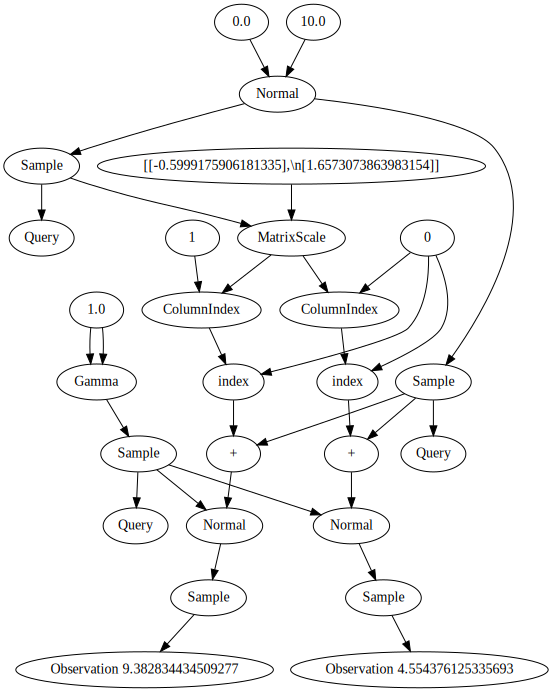

In [ ]:
BMGInference().to_graphviz(
    queries=[beta_0(), beta_1(), sigma()], observations={y(X_train[:2]): Y_train[:2]}
)
